In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import bloscpack as bp

import sys
import os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from annotation_utilities import *
from registration_utilities import *
from vis3d_utilities import *
from metadata import *
from data_manager import *

import time

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Precision WorkStation


No vtk


In [11]:
stack = 'M920'

In [12]:
if stack == 'M919':
    raw_data_dirs = \
    {('Nissl', 'down64'): os.path.join('/home/yuncong/LGN3Datlas', 'm919', 'STIF'),
    }
    
    input_image_filename_to_imagename_re_pattern_mapping = \
    {('Nissl', 'down64'): os.path.join('/home/yuncong/LGN3Datlas', 'm919', 'STIF', '(.*).tif'),
    }
elif stack == 'M920':
    raw_data_dirs = \
    {('Nissl', 'down64'): os.path.join('/home/yuncong/LGN3Datlas', 'm920', 'STIF'),
    }
    
    input_image_filename_to_imagename_re_pattern_mapping = \
    {('Nissl', 'down64'): os.path.join('/home/yuncong/LGN3Datlas', 'm920', 'STIF', '(.*).tif'),
    }
elif stack == 'M1144':
    raw_data_dirs = \
    {('Nissl', 'down64'): os.path.join('/home/yuncong/LGN3Datlas', 'm1144', 'STIF'),
    }
    
    input_image_filename_to_imagename_re_pattern_mapping = \
    {('Nissl', 'down64'): os.path.join('/home/yuncong/LGN3Datlas', 'm1144', 'STIF', '(.*).tif'),
    }
else:
    raise

In [17]:
image_names_all_data_dirs_flattened = set([])
image_names_all_data_dirs = {}
for vr, data_dir in raw_data_dirs.iteritems():
    if data_dir is None: continue
    image_names = set([])
    if vr in input_image_filename_to_imagename_re_pattern_mapping:
        for fn in os.listdir(data_dir):
            g = re.search(input_image_filename_to_imagename_re_pattern_mapping[vr], os.path.join(data_dir, fn))
            img_name = g.groups()[0]
            image_names.add(img_name)
            image_names_all_data_dirs_flattened.add(img_name)
    image_names_all_data_dirs[vr] = image_names
    
    
# Make sure the every image has all three channels.
for vr, img_names in image_names_all_data_dirs.iteritems():
    print vr, 'missing:' 
    print image_names_all_data_dirs_flattened - img_names
    print 

('Nissl', 'down64') missing:
set([])



In [18]:
print len(image_names_all_data_dirs_flattened), 'images are found.'

52 images are found.


In [19]:
# valid_filenames = sorted(list(image_names_all_data_dirs_flattened), key=lambda n: int(n.split('_')[-1]))

In [20]:
thumbnail_downscale_factor = 64

In [21]:
sections_to_filenames = {}
for img_name in image_names_all_data_dirs_flattened:
    sections_to_filenames[int(img_name.split('_')[-1])] = img_name

In [22]:
# Note that this could be the human-corrected version, in which case the transforms may not exist.
valid_filenames = sorted([fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)], 
                         key=lambda n: int(n.split('_')[-1]))
print len(valid_filenames), 'valid filenames'

52 valid filenames


In [23]:
tb_fmt = 'tif'

In [24]:
version = 'Nissl'

In [26]:
# Create the sorted image name file.

sorted_filelist_fp = DataManager.get_sorted_filenames_filename(stack=stack)

create_parent_dir_if_not_exists(sorted_filelist_fp)

with open(sorted_filelist_fp, 'w') as f:
    for img_name in valid_filenames:
        f.write('%s %d\n' % (img_name, int(img_name.split('_')[-1])))

In [27]:
for img_name in valid_filenames:
    in_fp = os.path.join(raw_data_dirs[('Nissl', 'down64')], img_name + '.tif')
    out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, version='Nissl', resol='down64', fn=img_name)
    
    create_parent_dir_if_not_exists(out_fp)
    execute_command('cp %s %s' % (in_fp, out_fp))

cp /home/yuncong/LGN3Datlas/m920/STIF/M920-N87--_2_0260.tif /data/CSHL_data_processed/M920/M920_down64_Nissl/M920-N87--_2_0260_down64_Nissl.tif
0
cp /home/yuncong/LGN3Datlas/m920/STIF/M920-N88--_2_0263.tif /data/CSHL_data_processed/M920/M920_down64_Nissl/M920-N88--_2_0263_down64_Nissl.tif
0
cp /home/yuncong/LGN3Datlas/m920/STIF/M920-N89--_2_0266.tif /data/CSHL_data_processed/M920/M920_down64_Nissl/M920-N89--_2_0266_down64_Nissl.tif
0
cp /home/yuncong/LGN3Datlas/m920/STIF/M920-N90--_2_0269.tif /data/CSHL_data_processed/M920/M920_down64_Nissl/M920-N90--_2_0269_down64_Nissl.tif
0
cp /home/yuncong/LGN3Datlas/m920/STIF/M920-N91--_2_0272.tif /data/CSHL_data_processed/M920/M920_down64_Nissl/M920-N91--_2_0272_down64_Nissl.tif
0
cp /home/yuncong/LGN3Datlas/m920/STIF/M920-N92--_2_0275.tif /data/CSHL_data_processed/M920/M920_down64_Nissl/M920-N92--_2_0275_down64_Nissl.tif
0
cp /home/yuncong/LGN3Datlas/m920/STIF/M920-N93--_2_0278.tif /data/CSHL_data_processed/M920/M920_down64_Nissl/M920-N93--_2_02

In [28]:
tb_resol = 'down64'

script = os.path.join(REPO_DIR, 'preprocess', 'align_consecutive_v2.py')
input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol=tb_resol)
output_dir = create_if_not_exists(os.path.join(THUMBNAIL_DATA_DIR, stack, stack + '_elastix_output'))

In [30]:
t = time.time()
print 'Align...'

run_distributed("%(script)s %(stack)s \"%(input_dir)s\" \"%(output_dir)s\" \'%%(kwargs_str)s\' %(fmt)s -p %(param_fp)s -r" % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'fmt': tb_fmt,
                 'param_fp': '/home/yuncong/Brain/preprocess/parameters/Parameters_Rigid_MutualInfo_noNumberOfSpatialSamples.txt'
                },
                kwargs_list=[{'prev_fn': valid_filenames[i-1] + '_' + tb_resol + '_' + version, 
                              'curr_fn': valid_filenames[i] + '_' + tb_resol + '_' + version,
                             'prev_sn': valid_filenames[i-1] ,
                             'curr_sn': valid_filenames[i] } 
                             for i in range(1, len(valid_filenames))],
                argument_type='list',
                jobs_per_node=4,
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 2252 seconds full stack

Align...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 1121.76981997 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [14]:
import re

final_metric = {}
for i in range(1, len(valid_filenames)):
#     if stack == 'ChatCryoJane201710':
#         prev_fn = valid_filenames[i-1] + '-Ntb'
#         curr_fn = valid_filenames[i] + '-Ntb'
#     else:
    prev_fn = valid_filenames[i-1]
    curr_fn = valid_filenames[i]

    with open(os.path.join(output_dir, curr_fn + '_to_' + prev_fn, 'elastix.log'), 'r') as f:
        t = f.read()
        g = re.search("Final metric value  = (.*?)\n", t)
#         final_metric[(curr_fn, prev_fn)] = -float(g.groups()[0])
        if g is None:
            print i
        final_metric[i] = float(g.groups()[0])

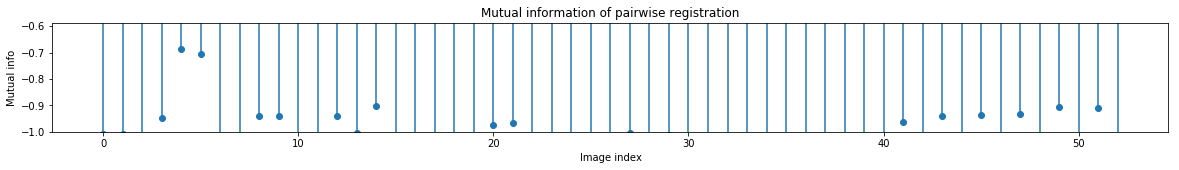

In [15]:
%matplotlib inline
metric_arr = np.array(final_metric.values())
plt.figure(figsize=(20,2));
plt.ylim([-1, metric_arr.max()+.1]);
plt.stem(metric_arr);
plt.title('Mutual information of pairwise registration');
plt.yticks(np.arange(-1, metric_arr.max()+.1, 0.1));
plt.xlabel('Image index');
plt.ylabel('Mutual info');

In [39]:
anchor_fp = DataManager.get_anchor_filename_filename(stack)

if not os.path.exists(anchor_fp):

    shapes = \
        [identify_shape(DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=None, version='Nissl', resol='down64'))
        for fn in valid_filenames]
    largest_idx = np.argmax([h*w for h, w in shapes])
    print 'largest section is ', largest_idx, valid_filenames[largest_idx]

    with open(anchor_fp, 'w') as f:
        f.write(valid_filenames[largest_idx])

In [14]:
anchor_fn = DataManager.load_anchor_filename(stack=stack)
anchor_idx = valid_filenames.index(anchor_fn)
print 'anchor_idx =', anchor_idx

anchor_idx = 0


In [41]:
script = os.path.join(REPO_DIR, 'preprocess', 'compose_transform_thumbnail_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')
output_fp = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                         dict(stack=stack, anchor_fn=anchor_fn))

execute_command('rm -f %s' % output_fp)

t = time.time()
print 'Composing transform...'

run_distributed("%(script)s %(stack)s \"%(input_dir)s\" \'%%(kwargs_str)s\' %(anchor_idx)d \"%(output_fp)s\"" % \
            {'stack': stack,
            'script': script,
            'input_dir': input_dir,
            'anchor_idx': anchor_idx,
            'output_fp': output_fp},
            kwargs_list=[{'filenames': valid_filenames}],
            argument_type='list',
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 20 seconds

rm -f /data/CSHL_data_processed/M919/M919_transformsTo_M919-N78--_2_0233.pkl
0
Composing transform...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 1.37391090393 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [15]:
# transforms_fp = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
#                                                 dict(stack=stack, anchor_fn=anchor_fn))
# download_from_s3(transforms_fp, redownload=True)

pad_bg_color = 'white'
prep_id = 1
version = 'Nissl'
tb_resol = 'down64'

input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol=tb_resol)
out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, resol=tb_resol, version=version)
print 'out_dir:', out_dir
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

execute_command('rm -r %s' % out_dir)

t = time.time()
print 'Warping...'


transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False, anchor_fn=anchor_fn)

if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
    run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s thumbnail 0 0 2000 1500 %%(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    },
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'input_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=None, version=version, resol=tb_resol),
                                  'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=prep_id, version=version, resol=tb_resol),
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8,
                   local_only=True)
else:
    run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s thumbnail 0 0 2000 1500 %(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'input_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=None, version=version, resol=tb_resol),
                                  'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=prep_id, version=version, resol=tb_resol),
                                 }
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8,
                   local_only=True)

# wait_qsub_complete()
    
print 'done in', time.time() - t, 'seconds' # 300 seconds.

out_dir: /data/CSHL_data_processed/M919/M919_prep1_down64_Nissl
rm -r /data/CSHL_data_processed/M919/M919_prep1_down64_Nissl
1
Warping...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 12.139496088 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
